In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,matthews_corrcoef


from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('../Feature Engineering/EPL_Final_cleaned_features_v2.csv')
df.head(5)

,Temperature,Humidity,WindDirection,Precipitation,WindSpeed,Home_Prv_FTHG,Home_Prv_HS,Home_Prv_HST,Home_Prv_HF,Home_Prv_HC,...,WeatherCode_Clear,WeatherCode_Clouds,WeatherCode_Drizzle,WeatherCode_Fog,WeatherCode_Haze,WeatherCode_Mist,WeatherCode_Rain,WeatherCode_Snow,Time_of_Day_Afternoon,Time_of_Day_Evening
0,1.589044,-0.947690,0.173322,-0.362486,1.677221,0.561811,0.043716,-0.045927,-0.171534,0.002643,...,0,1,0,0,0,0,0,0,1,0
1,1.917548,-0.815443,0.500378,-0.362486,1.280300,1.363757,2.156421,1.555162,-0.443552,1.065042,...,1,0,0,0,0,0,0,0,1,0
2,1.400248,-0.418701,0.816532,-0.362486,0.273563,0.561811,-0.340412,-0.846471,-1.259605,-0.351490,...,0,1,0,0,0,0,0,0,1,0
3,1.811823,-0.683196,0.500378,-0.362486,0.558625,0.561811,-1.300732,-0.446199,2.004609,-1.413890,...,0,0,0,0,0,0,1,0,1,0
4,2.011946,-0.881566,0.500378,-0.362486,0.558625,1.363757,0.811972,2.355707,0.100484,0.710909,...,1,0,0,0,0,0,0,0,1,0


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature                1072 non-null   float64
 1   Humidity                   1072 non-null   float64
 2   WindDirection              1072 non-null   float64
 3   Precipitation              1072 non-null   float64
 4   WindSpeed                  1072 non-null   float64
 5   Home_Prv_FTHG              1072 non-null   float64
 6   Home_Prv_HS                1072 non-null   float64
 7   Home_Prv_HST               1072 non-null   float64
 8   Home_Prv_HF                1072 non-null   float64
 9   Home_Prv_HC                1072 non-null   float64
 10  Home_Prv_HY                1072 non-null   float64
 11  Home_Prv_HR                1072 non-null   float64
 12  Away_Prv_FTAG              1072 non-null   float64
 13  Away_Prv_AS                1072 non-null   float

In [3]:
train_data = df[df['season'].isin(['2019-2020', '2020-2021'])]
test_data = df[df['season'] == '2021-2022']

### Model with Weather Data:

In [4]:
# Splitting into features and target variable
X_train = train_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam'])
y_train = train_data['FTR']
X_test = test_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam'])
y_test = test_data['FTR']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 51), (722,), (350, 51), (350,))

In [5]:
categorical_features = ['WeatherCode_Clear',
'WeatherCode_Clouds',
'WeatherCode_Drizzle',
'WeatherCode_Fog',
'WeatherCode_Haze',
'WeatherCode_Mist',
'WeatherCode_Rain',
'WeatherCode_Snow',
'Time_of_Day_Afternoon',
'Time_of_Day_Evening']

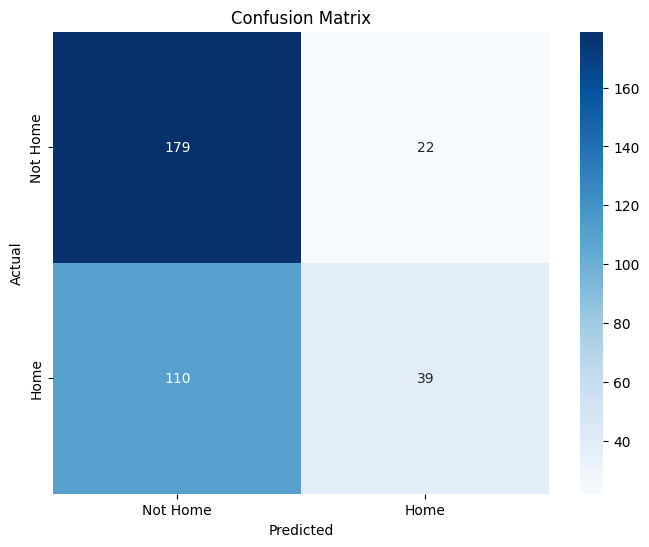

{'colsample_bytree': 1.0, 'enable_categorical': False, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
MCC: 0.19849751329123475
accuracy: 0.6228571428571429
              precision    recall  f1-score   support

           0       0.62      0.89      0.73       201
           1       0.64      0.26      0.37       149

    accuracy                           0.62       350
   macro avg       0.63      0.58      0.55       350
weighted avg       0.63      0.62      0.58       350



In [6]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Define the parameter grid for GridSearchCV
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'enable_categorical':[False]
}

# Using GridSearchCV to find the best hyperparameters (with weather data)
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Best parameters from GridSearch
best_params = grid_search_xgb.best_params_

# Building the XGBClassifier model with the best parameters
model_xgb = XGBClassifier(**best_params, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, y_train)

# Predicting on the test data
y_pred = model_xgb.predict(X_test)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [7]:
pd.DataFrame(y_pred,columns=['XGB_y_pred']).to_csv('4.XGB_y_pred_with_weather.csv')

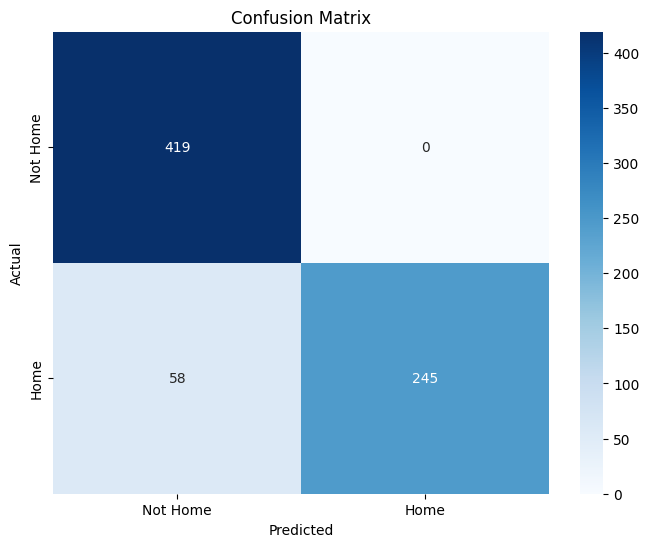

{'colsample_bytree': 1.0, 'enable_categorical': False, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
MCC: 0.8427709357734102
accuracy: 0.9196675900277008
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       419
           1       1.00      0.81      0.89       303

    accuracy                           0.92       722
   macro avg       0.94      0.90      0.91       722
weighted avg       0.93      0.92      0.92       722



In [8]:
# Predicting on the train data
y_train_pred = model_xgb.predict(X_train)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_train, y_train_pred)
accuracy = accuracy_score(y_train, y_train_pred)
classification_report_output = classification_report(y_train, y_train_pred)

cm = confusion_matrix(y_train, y_train_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

### Model without Weather Data:

In [9]:
X_train

,Home_Prv_FTHG,Home_Prv_HS,Home_Prv_HST,Home_Prv_HF,Home_Prv_HC,Home_Prv_HY,Home_Prv_HR,Away_Prv_FTAG,Away_Prv_AS,Away_Prv_AST,...,Away_Avg_3_AF,Away_Avg_3_AC,Away_Avg_3_AY,Away_Avg_3_AR,Home_Prv_3_Win,Away_Prv_3_Win,Home_Prv_FTR,Away_Prv_FTR,Time_of_Day_Afternoon,Time_of_Day_Evening
0,0.561811,0.043716,-0.045927,-0.171534,0.002643,1.089591,-0.254519,-0.333974,1.619744,-0.610880,...,-0.109988,-0.356420,1.053985,-0.403162,-0.143563,-0.190539,0.0,0.0,1,0
1,1.363757,2.156421,1.555162,-0.443552,1.065042,-0.539477,-0.254519,-0.333974,-0.917477,-0.610880,...,2.186904,0.235956,0.595247,-0.403162,-0.143563,-0.190539,0.0,0.0,1,0
2,0.561811,-0.340412,-0.846471,-1.259605,-0.351490,-1.354011,-0.254519,-0.333974,-0.555017,0.964258,...,-0.263114,0.038497,-0.780967,-0.403162,-0.143563,-0.190539,0.0,0.0,1,0
3,0.561811,-1.300732,-0.446199,2.004609,-1.413890,1.904126,-0.254519,0.447730,-1.098707,-0.610880,...,-0.416240,1.420708,-0.780967,-0.403162,-0.143563,-0.190539,0.0,1.0,1,0
4,1.363757,0.811972,2.355707,0.100484,0.710909,-0.539477,-0.254519,0.447730,-1.279937,0.176689,...,-0.722493,0.433415,-1.239705,-0.403162,-0.143563,-0.190539,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,0.561811,1.580229,-0.045927,0.644520,0.002643,-0.539477,-0.254519,0.447730,0.713593,0.570473,...,0.043138,0.828332,-0.322229,-0.403162,-0.143563,0.931756,0.0,1.0,1,0
718,1.363757,-1.108668,-0.446199,-0.987587,0.710909,-0.539477,-0.254519,1.229434,1.076053,0.570473,...,-0.722493,0.235956,0.595247,-0.403162,2.103151,-0.190539,0.0,1.0,1,0
719,-0.240135,-0.724540,0.354346,1.188556,-1.413890,1.089591,-0.254519,-0.333974,0.532363,0.176689,...,-0.722493,0.235956,-0.780967,-0.403162,-1.266920,0.931756,0.0,1.0,1,0
720,1.363757,1.772293,1.955435,0.100484,1.065042,0.275057,-0.254519,-1.115678,0.894823,-0.610880,...,1.115021,1.025791,-1.239705,-0.403162,-0.143563,0.931756,0.0,0.0,1,0


In [4]:
# Splitting into features and target variable
X_train = train_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam','Temperature', 'Humidity', 'WindDirection', 'Precipitation', 'WindSpeed', 
                                   'WeatherCode_Clear', 'WeatherCode_Clouds', 'WeatherCode_Drizzle', 'WeatherCode_Fog', 'WeatherCode_Haze', 'WeatherCode_Mist', 'WeatherCode_Rain', 'WeatherCode_Snow','Home_Prv_3_Win','Away_Prv_3_Win'])
y_train = train_data['FTR']
X_test = test_data.drop(columns=['FTR','Date', 'Time', 'season','HomeTeam','AwayTeam','Temperature', 'Humidity', 'WindDirection', 'Precipitation', 'WindSpeed', 
                                   'WeatherCode_Clear', 'WeatherCode_Clouds', 'WeatherCode_Drizzle', 'WeatherCode_Fog', 'WeatherCode_Haze', 'WeatherCode_Mist', 'WeatherCode_Rain', 'WeatherCode_Snow','Home_Prv_3_Win','Away_Prv_3_Win'])
y_test = test_data['FTR']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 38), (722,), (350, 38), (350,))

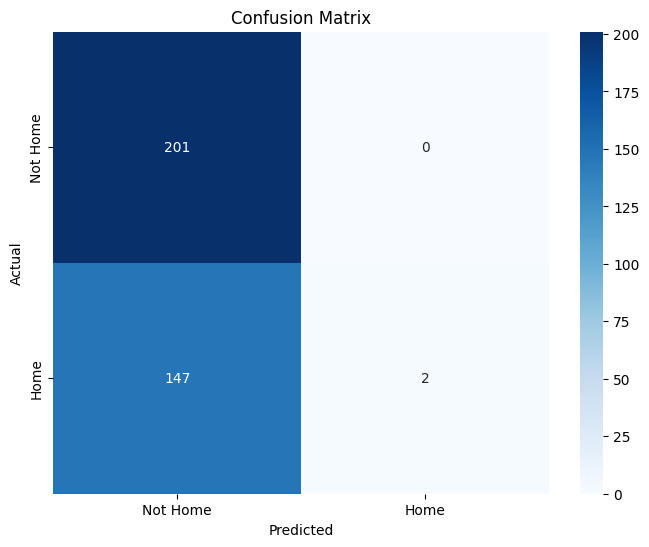

{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
MCC: 0.08805018450804078
accuracy: 0.58
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       201
           1       1.00      0.01      0.03       149

    accuracy                           0.58       350
   macro avg       0.79      0.51      0.38       350
weighted avg       0.76      0.58      0.43       350



In [13]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='error', random_state=1)

# Define the parameter grid for GridSearchCV
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': range(3,8),
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Using GridSearchCV to find the best hyperparameters (with weather data)
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=4, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Best parameters from GridSearch
best_params = grid_search_xgb.best_params_

# Building the XGBClassifier model with the best parameters
model_xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='error', random_state=1)
model_xgb.fit(X_train, y_train)

# Predicting on the test data
y_pred = model_xgb.predict(X_test)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [97]:
pd.DataFrame(y_pred,columns=['XGB_y_pred']).to_csv('4.XGB_y_pred_without_weather.csv')

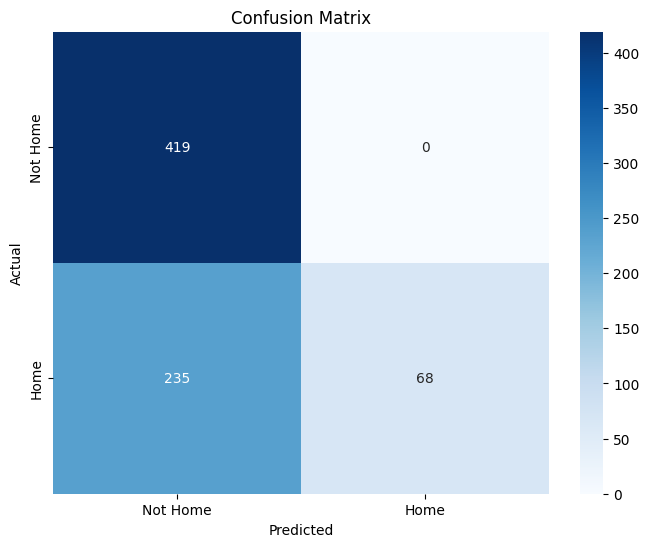

{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.6}
MCC: 0.3791851139115636
accuracy: 0.6745152354570637
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       419
           1       1.00      0.22      0.37       303

    accuracy                           0.67       722
   macro avg       0.82      0.61      0.57       722
weighted avg       0.79      0.67      0.61       722



In [98]:
# Predicting on the train data
y_train_pred = model_xgb.predict(X_train)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_train, y_train_pred)
accuracy = accuracy_score(y_train, y_train_pred)
classification_report_output = classification_report(y_train, y_train_pred)

cm = confusion_matrix(y_train, y_train_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)